# 对网络进行粒子群算法

In [15]:
import numpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt

data=pd.read_excel('C:/Users/XHM/Desktop/data/TFT/TFT_train.xlsx',engine='openpyxl')
all_input=data[['Vdrain','Vgate','W/L']].values
all_output=data['Idrain']
minmax=preprocessing.MinMaxScaler()
#all_output=minmax.fit_transform(data['Idrain'].values.reshape(-1,1))

(x_train,x_test,y_train,y_test)=train_test_split(all_input,all_output,train_size=0.8,
                                                 random_state=0)

#标准化处理

#x_train_s=minmax.fit_transform(x_train)
#x_test_s=minmax.fit_transform(x_test)



#数据类型处理
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.values)
test_xt=torch.from_numpy(x_test.astype(np.float32))
test_yt=torch.from_numpy(y_test.values)
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt.float())
test_data=Data.TensorDataset(test_xt,test_yt.float())

train_loader=Data.DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)



## fitness function

In [16]:
#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self,p):
        super(MLPregression,self).__init__()
        self.p=torch.from_numpy(p)
        self.p = self.p.to(torch.float32)
        #self.p=p
        self.activate=nn.LogSigmoid()
        #定义第一个隐藏层
        self.input=nn.Linear(in_features=3,out_features=28,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(28,24)
        #回归预测层
        self.predict=nn.Linear(24,1)
        #取出权重
        self.input.weight.data=self.p[0:84].reshape((28,3))
        self.input.bias.data=self.p[84:112].reshape((28,))
        self.hidden2.weight.data=self.p[112:784].reshape((24,28))
        self.hidden2.bias.data=self.p[784:808].reshape((24,))
        self.predict.weight.data=self.p[808:832].reshape((1,24))
        self.predict.bias.data=self.p[832:833]
    def forward(self,x):
        x=self.activate(self.input(x))
        x=self.activate(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]

#mlpreg.load_state_dict(torch.load("C:/Users/XHM/LEVIST/DIST/mlp_init_nosgd.pth"))

def fitness(x):
    mlpreg=MLPregression(p=x) 
    loss_func=nn.MSELoss()
    train_loss_all=[]
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        loss=loss_func(output,b_y)
    return loss




In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
class PSO():
    def __init__(self, parameters):
        """
        particle swarm optimization
        parameter: a list type, like [NGEN, pop_size, var_num_min, var_num_max]
        """
        # 初始化
        self.iters = parameters[0]    # 迭代的代数
        self.pop_size = 100    # 种群大小
        self.var_num =833    # 变量个数
        self.bound = []                 # 变量的约束范围
        self.bound.append(parameters[2])
        self.bound.append(parameters[3])
 
        self.pop_x = torch.zeros((self.pop_size, self.var_num))    # 所有粒子的位置
        self.pop_v = torch.zeros((self.pop_size, self.var_num))    # 所有粒子的速度
        self.p_best = torch.zeros((self.pop_size, self.var_num))   # 每个粒子最优的位置
        self.g_best = torch.zeros((self.var_num))   # 全局最优的位置
 
        # 初始化第0代初始全局最优解
        temp = 0.1
        for i in range(100):
            for j in range(self.var_num):
                self.pop_x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
                self.pop_v[i][j] = random.uniform(0, 1)
            self.p_best[i] = self.pop_x[i]      # 储存最优的个体
            fit = fitness(self.p_best[i])
            if fit < temp:
                self.g_best = self.p_best[i]
                temp = fit
    def update_operator(self, pop_size):
        """
        更新算子：更新下一时刻的位置和速度
        """
        c1 = 2     # 学习因子，一般为2
        c2 = 2
        w = 0.4    # 自身权重因子
        for i in range(self.pop_size):
            # 更新速度
            self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
                        self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.pop_x[i])
            # 更新位置
            self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
            # 越界保护
            for j in range(self.var_num):
                if self.pop_x[i][j] < self.bound[0][j]:
                    self.pop_x[i][j] = self.bound[0][j]
                if self.pop_x[i][j] > self.bound[1][j]:
                    self.pop_x[i][j] = self.bound[1][j]
            # 更新p_best和g_best

            if fitness(self.pop_x[i]) < fitness(self.p_best[i]):
                self.p_best[i] = self.pop_x[i]
                #print('size of g_best',self.g_best.size())
            if fitness(self.pop_x[i]) < fitness(self.g_best):
                self.g_best = self.pop_x[i]
 
    def main(self):
        popobj = []
        self.ng_best = torch.zeros((1, self.var_num))[0]
        for gen in range(self.iters):
            self.update_operator(self.pop_size)
            popobj.append(fitness(self.g_best))
            print('############ Generation {} ############'.format(str(gen + 1)))
            
            if fitness(self.g_best) < fitness(self.ng_best):
                self.ng_best = self.g_best.clone()
            print('最好的位置：{}'.format(self.ng_best))
            print('最小的loss：{}'.format(fitness(self.ng_best)))
        print("---- End of (successful) Searching ----")
 
        plt.figure()
        plt.title("Figure1")
        plt.xlabel("iterators", size=14)
        plt.ylabel("fitness", size=14)
        t = [t for t in range(self.iters)]
        plt.plot(t, popobj, color='b', linewidth=2)
        plt.show()
        
if __name__ == '__main__':
    iters= 100
    '''popsize = X_train.shape[0]'''
    popsize=833
    low = [0.001]*833
    up = [10]*833
    parameters = [iters, popsize, low, up]
    pso = PSO(parameters)
    pso.main()

############ Generation 1 ############
最好的位置：tensor([6.3923e+00, 8.9196e+00, 2.4333e+00, 8.4008e+00, 3.5443e+00, 6.5730e+00,
        4.7134e+00, 5.3336e+00, 1.0000e-03, 1.5720e+00, 7.4169e+00, 5.9927e+00,
        5.9710e+00, 5.5727e+00, 2.7478e+00, 4.3893e+00, 4.7533e+00, 3.7799e+00,
        6.2453e+00, 6.6478e+00, 9.9629e+00, 6.9664e+00, 1.0000e+01, 7.6342e+00,
        3.9222e+00, 6.9304e+00, 2.3464e+00, 5.6901e+00, 4.4817e+00, 6.0763e+00,
        5.1399e+00, 5.0645e+00, 3.5007e+00, 6.3573e+00, 8.0867e+00, 7.1707e+00,
        5.4360e+00, 1.0000e+01, 9.5052e+00, 7.1207e+00, 2.0569e+00, 1.0000e+01,
        2.7531e+00, 3.1297e+00, 6.2381e+00, 1.0000e+01, 9.3066e+00, 7.1329e+00,
        7.8362e+00, 6.4970e+00, 7.1876e+00, 6.6104e+00, 4.7073e+00, 4.3383e+00,
        6.2068e+00, 1.0000e+01, 7.4512e+00, 4.4902e+00, 6.9403e+00, 8.0868e+00,
        4.8466e+00, 6.6087e+00, 9.2889e+00, 8.2753e+00, 8.0683e+00, 9.6105e+00,
        4.2024e+00, 5.4997e+00, 7.1993e+00, 6.4641e+00, 1.5044e+00, 3.8367e

############ Generation 2 ############
最好的位置：tensor([6.3923e+00, 8.9196e+00, 2.4333e+00, 8.4008e+00, 3.5443e+00, 6.5730e+00,
        4.7134e+00, 5.3336e+00, 1.0000e-03, 1.5720e+00, 7.4169e+00, 5.9927e+00,
        5.9710e+00, 5.5727e+00, 2.7478e+00, 4.3893e+00, 4.7533e+00, 3.7799e+00,
        6.2453e+00, 6.6478e+00, 9.9629e+00, 6.9664e+00, 1.0000e+01, 7.6342e+00,
        3.9222e+00, 6.9304e+00, 2.3464e+00, 5.6901e+00, 4.4817e+00, 6.0763e+00,
        5.1399e+00, 5.0645e+00, 3.5007e+00, 6.3573e+00, 8.0867e+00, 7.1707e+00,
        5.4360e+00, 1.0000e+01, 9.5052e+00, 7.1207e+00, 2.0569e+00, 1.0000e+01,
        2.7531e+00, 3.1297e+00, 6.2381e+00, 1.0000e+01, 9.3066e+00, 7.1329e+00,
        7.8362e+00, 6.4970e+00, 7.1876e+00, 6.6104e+00, 4.7073e+00, 4.3383e+00,
        6.2068e+00, 1.0000e+01, 7.4512e+00, 4.4902e+00, 6.9403e+00, 8.0868e+00,
        4.8466e+00, 6.6087e+00, 9.2889e+00, 8.2753e+00, 8.0683e+00, 9.6105e+00,
        4.2024e+00, 5.4997e+00, 7.1993e+00, 6.4641e+00, 1.5044e+00, 3.8367e

############ Generation 3 ############
最好的位置：tensor([6.3923e+00, 8.9196e+00, 2.4333e+00, 8.4008e+00, 3.5443e+00, 6.5730e+00,
        4.7134e+00, 5.3336e+00, 1.0000e-03, 1.5720e+00, 7.4169e+00, 5.9927e+00,
        5.9710e+00, 5.5727e+00, 2.7478e+00, 4.3893e+00, 4.7533e+00, 3.7799e+00,
        6.2453e+00, 6.6478e+00, 9.9629e+00, 6.9664e+00, 1.0000e+01, 7.6342e+00,
        3.9222e+00, 6.9304e+00, 2.3464e+00, 5.6901e+00, 4.4817e+00, 6.0763e+00,
        5.1399e+00, 5.0645e+00, 3.5007e+00, 6.3573e+00, 8.0867e+00, 7.1707e+00,
        5.4360e+00, 1.0000e+01, 9.5052e+00, 7.1207e+00, 2.0569e+00, 1.0000e+01,
        2.7531e+00, 3.1297e+00, 6.2381e+00, 1.0000e+01, 9.3066e+00, 7.1329e+00,
        7.8362e+00, 6.4970e+00, 7.1876e+00, 6.6104e+00, 4.7073e+00, 4.3383e+00,
        6.2068e+00, 1.0000e+01, 7.4512e+00, 4.4902e+00, 6.9403e+00, 8.0868e+00,
        4.8466e+00, 6.6087e+00, 9.2889e+00, 8.2753e+00, 8.0683e+00, 9.6105e+00,
        4.2024e+00, 5.4997e+00, 7.1993e+00, 6.4641e+00, 1.5044e+00, 3.8367e

############ Generation 4 ############
最好的位置：tensor([5.7098e+00, 3.5274e+00, 3.3076e+00, 5.1419e+00, 3.3724e+00, 3.0919e+00,
        5.4932e+00, 2.7050e+00, 3.6321e+00, 6.7449e+00, 1.4655e+00, 2.8174e+00,
        8.5908e+00, 3.2094e+00, 7.1778e+00, 5.7177e+00, 7.7594e+00, 7.1994e+00,
        4.4092e+00, 5.1171e+00, 8.3815e+00, 8.8376e+00, 6.6199e+00, 9.4263e+00,
        2.1672e+00, 8.2824e+00, 7.4785e+00, 7.3012e+00, 1.7730e+00, 3.8893e+00,
        2.1796e+00, 3.9315e+00, 3.7105e+00, 8.2357e+00, 4.9945e+00, 2.3200e+00,
        5.2122e+00, 7.8507e+00, 6.5269e+00, 5.5085e+00, 3.7239e+00, 9.4131e+00,
        3.7359e+00, 7.4123e+00, 3.1419e+00, 8.7484e+00, 5.1988e+00, 3.1046e+00,
        8.4544e+00, 6.3866e+00, 2.2610e+00, 7.6853e+00, 6.4267e+00, 4.2580e+00,
        8.2384e+00, 5.2495e+00, 3.0283e+00, 7.5287e+00, 5.5233e+00, 7.2655e+00,
        5.7214e+00, 3.3965e+00, 8.4406e+00, 9.2711e+00, 4.7451e+00, 4.4958e+00,
        1.6399e+00, 6.8442e+00, 3.2211e+00, 8.5463e+00, 4.7983e+00, 5.3195e

############ Generation 5 ############
最好的位置：tensor([5.7098e+00, 3.5274e+00, 3.3076e+00, 5.1419e+00, 3.3724e+00, 3.0919e+00,
        5.4932e+00, 2.7050e+00, 3.6321e+00, 6.7449e+00, 1.4655e+00, 2.8174e+00,
        8.5908e+00, 3.2094e+00, 7.1778e+00, 5.7177e+00, 7.7594e+00, 7.1994e+00,
        4.4092e+00, 5.1171e+00, 8.3815e+00, 8.8376e+00, 6.6199e+00, 9.4263e+00,
        2.1672e+00, 8.2824e+00, 7.4785e+00, 7.3012e+00, 1.7730e+00, 3.8893e+00,
        2.1796e+00, 3.9315e+00, 3.7105e+00, 8.2357e+00, 4.9945e+00, 2.3200e+00,
        5.2122e+00, 7.8507e+00, 6.5269e+00, 5.5085e+00, 3.7239e+00, 9.4131e+00,
        3.7359e+00, 7.4123e+00, 3.1419e+00, 8.7484e+00, 5.1988e+00, 3.1046e+00,
        8.4544e+00, 6.3866e+00, 2.2610e+00, 7.6853e+00, 6.4267e+00, 4.2580e+00,
        8.2384e+00, 5.2495e+00, 3.0283e+00, 7.5287e+00, 5.5233e+00, 7.2655e+00,
        5.7214e+00, 3.3965e+00, 8.4406e+00, 9.2711e+00, 4.7451e+00, 4.4958e+00,
        1.6399e+00, 6.8442e+00, 3.2211e+00, 8.5463e+00, 4.7983e+00, 5.3195e

############ Generation 6 ############
最好的位置：tensor([5.7098e+00, 3.5274e+00, 3.3076e+00, 5.1419e+00, 3.3724e+00, 3.0919e+00,
        5.4932e+00, 2.7050e+00, 3.6321e+00, 6.7449e+00, 1.4655e+00, 2.8174e+00,
        8.5908e+00, 3.2094e+00, 7.1778e+00, 5.7177e+00, 7.7594e+00, 7.1994e+00,
        4.4092e+00, 5.1171e+00, 8.3815e+00, 8.8376e+00, 6.6199e+00, 9.4263e+00,
        2.1672e+00, 8.2824e+00, 7.4785e+00, 7.3012e+00, 1.7730e+00, 3.8893e+00,
        2.1796e+00, 3.9315e+00, 3.7105e+00, 8.2357e+00, 4.9945e+00, 2.3200e+00,
        5.2122e+00, 7.8507e+00, 6.5269e+00, 5.5085e+00, 3.7239e+00, 9.4131e+00,
        3.7359e+00, 7.4123e+00, 3.1419e+00, 8.7484e+00, 5.1988e+00, 3.1046e+00,
        8.4544e+00, 6.3866e+00, 2.2610e+00, 7.6853e+00, 6.4267e+00, 4.2580e+00,
        8.2384e+00, 5.2495e+00, 3.0283e+00, 7.5287e+00, 5.5233e+00, 7.2655e+00,
        5.7214e+00, 3.3965e+00, 8.4406e+00, 9.2711e+00, 4.7451e+00, 4.4958e+00,
        1.6399e+00, 6.8442e+00, 3.2211e+00, 8.5463e+00, 4.7983e+00, 5.3195e

############ Generation 7 ############
最好的位置：tensor([8.4118e-01, 1.0000e+01, 1.6522e-01, 5.7239e+00, 6.7114e+00, 4.1406e+00,
        7.3201e+00, 1.0000e-03, 8.2613e+00, 1.0000e+01, 4.3958e+00, 6.9964e+00,
        1.0000e+01, 1.0000e+01, 2.5445e+00, 1.4370e+00, 5.7452e+00, 9.5737e+00,
        5.8539e+00, 5.7114e+00, 9.6508e+00, 3.0840e+00, 1.0000e+01, 8.8771e+00,
        1.0000e-03, 8.8781e+00, 1.0000e+01, 4.6192e+00, 2.7171e+00, 7.9289e+00,
        9.4393e+00, 3.0229e+00, 2.6737e+00, 9.4608e+00, 1.0000e+01, 6.4284e+00,
        6.2985e+00, 1.0000e+01, 6.9842e+00, 1.0000e+01, 1.0000e-03, 1.0000e+01,
        1.0000e-03, 8.8641e+00, 1.8300e+00, 1.0000e+01, 1.0000e+01, 2.7838e+00,
        7.3772e+00, 5.0912e+00, 1.7168e-01, 5.6260e+00, 1.0000e+01, 3.1292e+00,
        2.3240e+00, 4.1206e+00, 7.5750e+00, 1.0000e+01, 1.0000e+01, 6.7058e+00,
        5.0648e+00, 1.0000e-03, 9.4736e+00, 7.2545e+00, 1.0000e+01, 1.0000e+01,
        5.7797e-02, 1.0000e-03, 1.0000e+01, 9.5822e+00, 2.5377e+00, 2.7713e

############ Generation 8 ############
最好的位置：tensor([8.4118e-01, 1.0000e+01, 1.6522e-01, 5.7239e+00, 6.7114e+00, 4.1406e+00,
        7.3201e+00, 1.0000e-03, 8.2613e+00, 1.0000e+01, 4.3958e+00, 6.9964e+00,
        1.0000e+01, 1.0000e+01, 2.5445e+00, 1.4370e+00, 5.7452e+00, 9.5737e+00,
        5.8539e+00, 5.7114e+00, 9.6508e+00, 3.0840e+00, 1.0000e+01, 8.8771e+00,
        1.0000e-03, 8.8781e+00, 1.0000e+01, 4.6192e+00, 2.7171e+00, 7.9289e+00,
        9.4393e+00, 3.0229e+00, 2.6737e+00, 9.4608e+00, 1.0000e+01, 6.4284e+00,
        6.2985e+00, 1.0000e+01, 6.9842e+00, 1.0000e+01, 1.0000e-03, 1.0000e+01,
        1.0000e-03, 8.8641e+00, 1.8300e+00, 1.0000e+01, 1.0000e+01, 2.7838e+00,
        7.3772e+00, 5.0912e+00, 1.7168e-01, 5.6260e+00, 1.0000e+01, 3.1292e+00,
        2.3240e+00, 4.1206e+00, 7.5750e+00, 1.0000e+01, 1.0000e+01, 6.7058e+00,
        5.0648e+00, 1.0000e-03, 9.4736e+00, 7.2545e+00, 1.0000e+01, 1.0000e+01,
        5.7797e-02, 1.0000e-03, 1.0000e+01, 9.5822e+00, 2.5377e+00, 2.7713e

############ Generation 9 ############
最好的位置：tensor([8.4118e-01, 1.0000e+01, 1.6522e-01, 5.7239e+00, 6.7114e+00, 4.1406e+00,
        7.3201e+00, 1.0000e-03, 8.2613e+00, 1.0000e+01, 4.3958e+00, 6.9964e+00,
        1.0000e+01, 1.0000e+01, 2.5445e+00, 1.4370e+00, 5.7452e+00, 9.5737e+00,
        5.8539e+00, 5.7114e+00, 9.6508e+00, 3.0840e+00, 1.0000e+01, 8.8771e+00,
        1.0000e-03, 8.8781e+00, 1.0000e+01, 4.6192e+00, 2.7171e+00, 7.9289e+00,
        9.4393e+00, 3.0229e+00, 2.6737e+00, 9.4608e+00, 1.0000e+01, 6.4284e+00,
        6.2985e+00, 1.0000e+01, 6.9842e+00, 1.0000e+01, 1.0000e-03, 1.0000e+01,
        1.0000e-03, 8.8641e+00, 1.8300e+00, 1.0000e+01, 1.0000e+01, 2.7838e+00,
        7.3772e+00, 5.0912e+00, 1.7168e-01, 5.6260e+00, 1.0000e+01, 3.1292e+00,
        2.3240e+00, 4.1206e+00, 7.5750e+00, 1.0000e+01, 1.0000e+01, 6.7058e+00,
        5.0648e+00, 1.0000e-03, 9.4736e+00, 7.2545e+00, 1.0000e+01, 1.0000e+01,
        5.7797e-02, 1.0000e-03, 1.0000e+01, 9.5822e+00, 2.5377e+00, 2.7713e

In [ ]:
a=pso.ng_best   #取出最优的参数
print(a)
torch.save(a,"C:/Users/XHM/LEVIST/DIST/write_a_int.pth")    # 保存Tensor为pth文件
b=torch.load("C:/Users/XHM/LEVIST/DIST/write_a_int.pth")   # 加载出这个参数
print(b)

## 搜索

In [17]:
from sko.PSO import PSO

pso = PSO(func=fitness, dim=833, pop=1000, max_iter=200, lb=[0.001]*833, ub=[10]*833, w=0.4, c1=2, c2=2)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)
torch.save(pso.gbest_x,"C:/Users/XHM/LEVIST/DIST/pso.gbest_x.pth")    # 保存Tensor为pth文件

best_x is  [1.00000000e-03 2.48708574e+00 4.13586825e+00 2.64346050e+00
 8.94067722e+00 1.34083447e+00 4.97366336e+00 5.24319968e+00
 6.05870811e+00 1.00000000e+01 4.15116096e+00 3.08467351e-01
 7.82623731e-02 7.71828615e+00 8.64169918e+00 4.38487227e+00
 1.00000000e+01 1.00000000e-03 1.00000000e-03 6.15274380e+00
 1.00000000e-03 5.46122175e+00 1.00000000e+01 1.00000000e-03
 5.56264816e-01 9.90052495e+00 3.67156088e+00 1.00000000e+01
 1.00000000e-03 3.74734743e+00 1.00000000e+01 5.90913169e+00
 1.00000000e+01 3.07457716e+00 1.00000000e+01 6.44783800e+00
 1.00000000e-03 1.86800590e+00 4.46822940e+00 2.90241966e+00
 4.21348802e+00 8.28480228e+00 1.74939962e+00 6.27829661e+00
 1.02058886e+00 1.00000000e+01 6.02721166e+00 1.00000000e+01
 3.10786038e+00 4.89772657e+00 7.62636845e+00 9.98816933e+00
 1.00000000e-03 2.77169448e+00 7.86334310e+00 4.12782593e+00
 6.78017706e+00 3.76756610e+00 4.70888120e+00 5.05222742e+00
 5.58220387e+00 6.90988161e+00 8.43541973e+00 1.00000000e-03
 1.28310883e+

In [19]:
d=torch.load("C:/Users/XHM/LEVIST/DIST/pso.gbest_x.pth")   # 加载出这个参数
d=torch.Tensor(d)
t = d.to(torch.float32)
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        self.activate=nn.LogSigmoid()
        #定义第一个隐藏层
        self.input=nn.Linear(in_features=3,out_features=28,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(28,24)
        #回归预测层
        self.predict=nn.Linear(24,1)
        #取出权重
        self.input.weight.data=t[0:84].reshape((28,3))
        self.input.bias.data=t[84:112].reshape((28,))
        self.hidden2.weight.data=t[112:784].reshape((24,28))
        self.hidden2.bias.data=t[784:808].reshape((24,))
        self.predict.weight.data=t[808:832].reshape((1,24))
        self.predict.bias.data=t[832:833]
    def forward(self,x):
        x=self.activate(self.input(x))
        x=self.activate(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]
mlp=MLPregression()
torch.save(mlp.state_dict(),"C:/Users/XHM/LEVIST/DIST/mlp_init_pso.pth") 
print(mlp.input.weight.data)

tensor([[1.0000e-03, 2.4871e+00, 4.1359e+00],
        [2.6435e+00, 8.9407e+00, 1.3408e+00],
        [4.9737e+00, 5.2432e+00, 6.0587e+00],
        [1.0000e+01, 4.1512e+00, 3.0847e-01],
        [7.8262e-02, 7.7183e+00, 8.6417e+00],
        [4.3849e+00, 1.0000e+01, 1.0000e-03],
        [1.0000e-03, 6.1527e+00, 1.0000e-03],
        [5.4612e+00, 1.0000e+01, 1.0000e-03],
        [5.5626e-01, 9.9005e+00, 3.6716e+00],
        [1.0000e+01, 1.0000e-03, 3.7473e+00],
        [1.0000e+01, 5.9091e+00, 1.0000e+01],
        [3.0746e+00, 1.0000e+01, 6.4478e+00],
        [1.0000e-03, 1.8680e+00, 4.4682e+00],
        [2.9024e+00, 4.2135e+00, 8.2848e+00],
        [1.7494e+00, 6.2783e+00, 1.0206e+00],
        [1.0000e+01, 6.0272e+00, 1.0000e+01],
        [3.1079e+00, 4.8977e+00, 7.6264e+00],
        [9.9882e+00, 1.0000e-03, 2.7717e+00],
        [7.8633e+00, 4.1278e+00, 6.7802e+00],
        [3.7676e+00, 4.7089e+00, 5.0522e+00],
        [5.5822e+00, 6.9099e+00, 8.4354e+00],
        [1.0000e-03, 1.2831e+00, 1

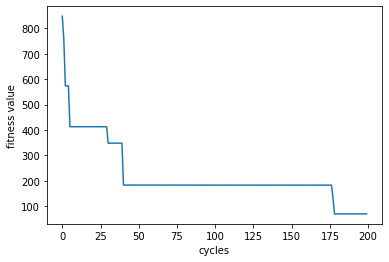

In [20]:
import matplotlib.pyplot as plt
plt.plot(pso.gbest_y_hist,label="pso")
plt.xlabel("cycles")
plt.ylabel("fitness value")
plt.show()